In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from torch import nn

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor()
)

print('Shape of image:', training_data[0][0].shape)

train_dataloader = DataLoader(training_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)



Shape of image: torch.Size([1, 28, 28])


In [3]:
len(test_data)

10000

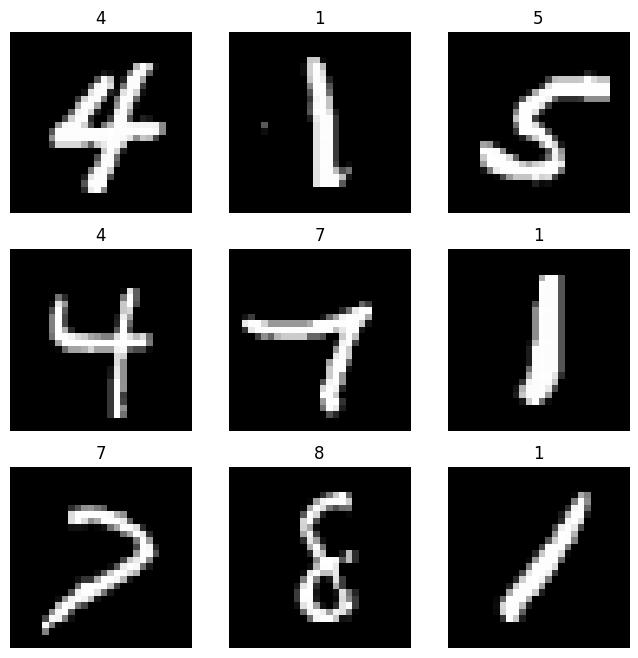

In [4]:
labels_map = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()



# Build Model #

### This time build autoencoder with convolutional Layers


In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 32, kernel_size=3, stride=2,padding=1),
                        nn.ReLU())
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 64, kernel_size=3, stride=2,padding=1),
                        nn.ReLU())
        self.dense = nn.Sequential(
                        nn.Linear(3136,2),
                        nn.ReLU())
        
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        print(x.shape)
        x = self.conv1(x) # Output shape: torch.Size([1, 32, 14, 14])
        x = self.conv2(x) # Output shape: torch.Size([1, 64, 7, 7])

        x = self.flatten(x) # Output shape: torch.Size([1, 3136])

        x = self.dense(x) # Output shape: torch.Size([1, 2])

        return(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(2,3136),
            nn.ReLU()
        )
        self.transpconv1 = nn.Sequential(
                    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2,padding=1),
                    nn.ReLU()

        )
        self.transpconv2 = nn.Sequential(
                    nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2,padding=1),
                    nn.ReLU()

        )
        self.output = nn.Sequential(
                    nn.ConvTranspose2d(32, 1, kernel_size=1, stride=1,padding=0),
                    nn.Sigmoid())

    
    def forward(self, x):
        x = self.dense(x)
        x = x.view(-1, 64, 7, 7 ) # Output shape: torch.Size([1, 64, 7, 7])
        x = self.transpconv1(x) # Output shape: torch.Size([1, 32, 14, 14])

        x = self.transpconv2(x) # Output shape: torch.Size([1, 32, 28, 28])
        x = self.output(x)
        return x


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encode = Encoder()
        self.decode = Decoder()


    def forward(self, x, return_latent=False):
        if return_latent:
            x = self.encode(x)
            latent = x.clone()
            x = self.decode(x)
            return x, latent
        else:
            x = self.encode(x)
            x = self.decode(x)
            return x


encoder = Encoder()
decoder = Decoder()
autoencoder = AutoEncoder() 

random_tensor = torch.randn(32,1,28,28)

latent_test = encoder(random_tensor)
output_test = decoder(latent_test)

whole_test = autoencoder(random_tensor)
print(latent_test.shape)


torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 2])


torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


Text(0.5, 1.0, 'Model Output (untrained)')

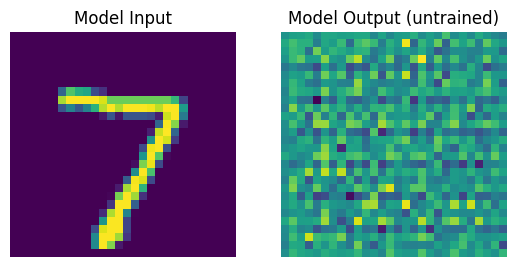

In [6]:
autoencoder = AutoEncoder() 

test_img, test_label = test_data[0]

print(test_img.shape)

test_pred = autoencoder(test_img.unsqueeze(0))

print(test_pred.shape)

fix,ax = plt.subplots(1,2)
ax[0].imshow(np.squeeze(np.array(test_img)))
ax[0].axis('off')
ax[0].set_title('Model Input')

ax[1].imshow(np.squeeze(test_pred.detach().numpy()))
ax[1].axis('off')
ax[1].set_title('Model Output (untrained)')




# Traine Da Model #

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        # Compute prediction and loss
        # Move data to the device
        X = X.to(device)
        pred = model(X)
        loss = loss_fn(pred, X)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, _ in dataloader:
            # Move data to the device
            X = X.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, X.view(-1,28*28)).item()

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")


: 

In [8]:
learning_rate = 1e-4
epochs = 1
batch_size= 32

loss = nn.MSELoss()

model = AutoEncoder().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss, optimizer)
    test_loop(test_dataloader, model, loss)
print("Done!")

Epoch 1
-------------------------------
torch.Size([32, 1, 28, 28])
